# Parsing Jail Logs With `pdfplumber`

This notebook demonstrates one way to use `pdfplumber` to parse the Stanislaus County Sheriff's Department's "In Custody Report" PDF.

In [1]:
import pdfplumber

## Load the PDF

In [2]:
pdf = pdfplumber.open("../pdfs/stanislaus-jail-log-2016-05-27.pdf")

## Analyze the first page

In [3]:
p0 = pdf.pages[0]

Here's what the first page looks like:

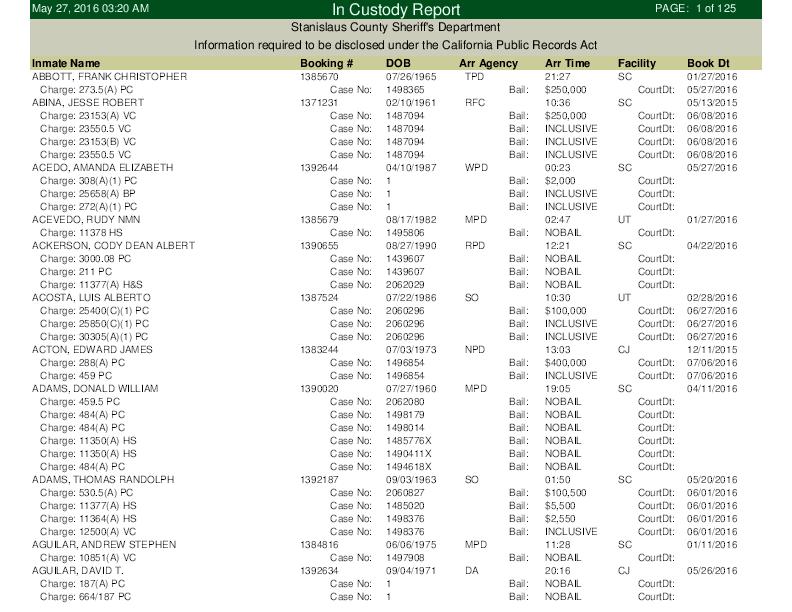

In [4]:
im = p0.to_image()
im

### Find the column positions

We can use `pdfplumber`'s visual debugging tools to figure out the `x`-coordinates that separate the PDF's seven columns. We can adjust the values in `VLINES` until they're flush with the colums:

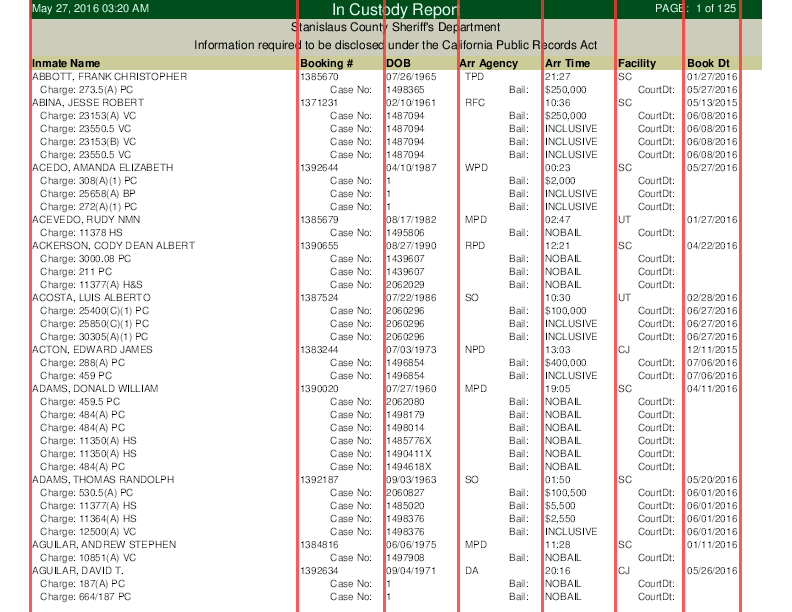

In [5]:
VLINES = [ 30, 297, 384, 458, 542, 615, 683, 740 ]
im.reset().draw_vlines(VLINES, stroke_width=3)

### Crop the page

Because we don't want the text from the page's header, we crop that out:

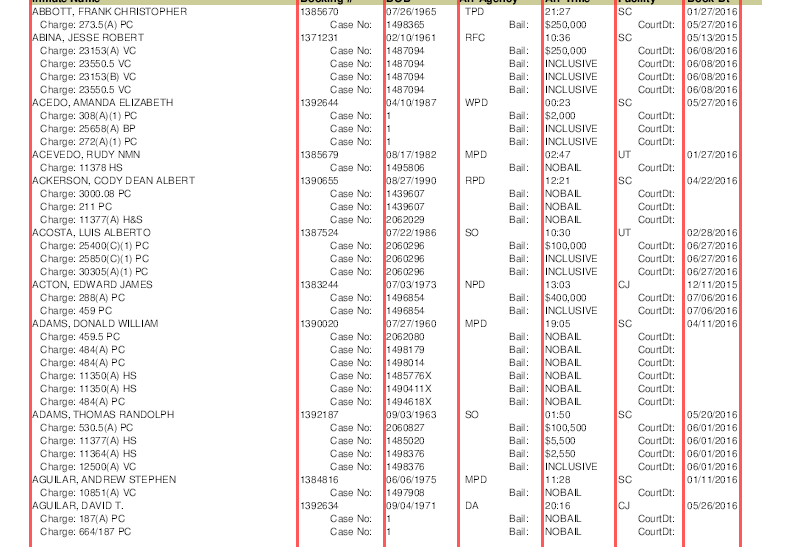

In [6]:
cropped = p0.within_bbox((0, 65, p0.width, p0.height))
cropped_im = cropped.to_image()
cropped_im.draw_vlines(VLINES, stroke_width=3)

### Extract the table

Because each row is indicated by the alignment of the text (rather than literal lines), we tell `pdfplumber` to use the "text" strategy to find the horizontal cell borders. And we use the `VLINES` from above to demarcate the vertical borders. We can use `PageImage.debug_tablefinder(...)` to check whether this is working:

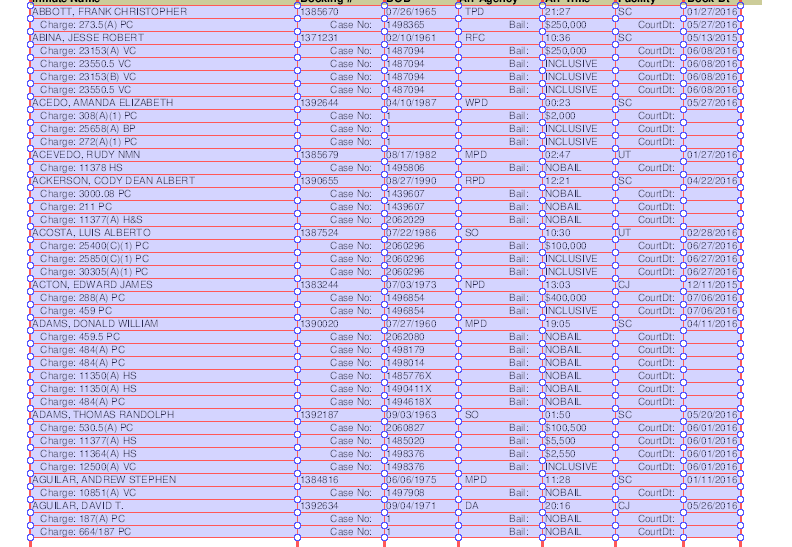

In [7]:
TABLE_SETTINGS = {
    "horizontal_strategy": "text",
    "vertical_strategy": "explicit",
    "explicit_vertical_lines": VLINES,
}
cropped_im.debug_tablefinder(TABLE_SETTINGS)

It looks like it's working, so let's extract the table:

In [8]:
table = cropped.extract_table(TABLE_SETTINGS)

Here are the first three rows of the extracted data:

In [9]:
table[:3]

[['ABBOTT, FRANK CHRISTOPHER',
  '1385670',
  '07/26/1965',
  'TPD',
  '21:27',
  'SC',
  '01/27/2016'],
 ['Charge: 273.5(A) PC',
  'Case No:',
  '1498365',
  'Bail:',
  '$250,000',
  'CourtDt:',
  '05/27/2016'],
 ['ABINA, JESSE ROBERT',
  '1371231',
  '02/10/1961',
  'RFC',
  '10:36',
  'SC',
  '05/13/2015']]

## Generalize the extractor to work on any page

Above, we worked directly with the first page. Below, we write a function that can be applied to *any* page:

In [10]:
def parse_page(page):
    cropped = page.within_bbox((0, 65, page.width, page.height))
    table = cropped.extract_table(TABLE_SETTINGS)
    return table

## Extract data from the first 10 pages

In [11]:
%%time
rows = []
# Remove the [:10] if you want to parse all the pages
for page in pdf.pages[:10]:
    rows += parse_page(page)

CPU times: user 8.11 s, sys: 125 ms, total: 8.23 s
Wall time: 8.37 s


In [12]:
len(rows)

410

## Collate the inmate- and charge-rows

The jail logs don't follow a typical spreadsheet convention; instead some rows represent individual inmates, while others represent indiviual charges. The code below loops through the rows, and collates the data on an inmate-by-inmate basis:

In [13]:
inmates = []
current_inmate = None
for row in rows:
    is_inmate_row = "Charge: " not in row[0]
    if is_inmate_row:
        current_inmate = {
            "name": row[0],
            "booking_no": row[1],
            "date_of_birth": row[2],
            "arresting_agency": row[3],
            "arrival_time": row[4],
            "facility": row[5],
            "book_date": row[6],
            "charges": []
        }
        inmates.append(current_inmate)
    else:
        current_inmate["charges"].append({
            "charge": row[0].split("Charge: ", 1)[1],
            "case_no": row[2],
            "bail": row[4],
            "court_date": row[6]
        })

In [14]:
len(inmates)

96

Here's what the data looks like for the first three inmates:

In [15]:
import json

In [16]:
for inmate in inmates[:3]:
    print(json.dumps(inmate, indent=2))
    print("\n---\n")

{
  "charges": [
    {
      "charge": "273.5(A) PC",
      "court_date": "05/27/2016",
      "case_no": "1498365",
      "bail": "$250,000"
    }
  ],
  "date_of_birth": "07/26/1965",
  "facility": "SC",
  "arrival_time": "21:27",
  "booking_no": "1385670",
  "arresting_agency": "TPD",
  "name": "ABBOTT, FRANK CHRISTOPHER",
  "book_date": "01/27/2016"
}

---

{
  "charges": [
    {
      "charge": "23153(A) VC",
      "court_date": "06/08/2016",
      "case_no": "1487094",
      "bail": "$250,000"
    },
    {
      "charge": "23550.5 VC",
      "court_date": "06/08/2016",
      "case_no": "1487094",
      "bail": "INCLUSIVE"
    },
    {
      "charge": "23153(B) VC",
      "court_date": "06/08/2016",
      "case_no": "1487094",
      "bail": "INCLUSIVE"
    },
    {
      "charge": "23550.5 VC",
      "court_date": "06/08/2016",
      "case_no": "1487094",
      "bail": "INCLUSIVE"
    }
  ],
  "date_of_birth": "02/10/1961",
  "facility": "SC",
  "arrival_time": "10:36",
  "booking_

If you wanted to save the inmate data, you could write it out as a JSON file:

In [17]:
# with open("inmates.json", "w") as f:
#     json.dump(inmates, f, indent=2)

---

---

---